# Program - plot cn_map using cartopy

**Purpose**


**Content**
- read data
- using an xarray function, interp_like, to interpolate data on one lat/lon grid to another lat/lon grid
- plot cn_map using cartopy

**Author:** Yi-Hsuan Chen (yihsuan@umich.edu)

**Date:** May 24, 2023

**Reference program:**



In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read data

### TaiESM1 data

In [2]:
#--- datapath
datapath_TaiESM1 = "../data_test/"
fnames_rsut = [
    "TaiESM1_amip-hist-test.nc",
]
fnames_rsut = [datapath_TaiESM1+"/"+file1 for file1 in fnames_rsut]

da_rsut = xr.open_mfdataset(fnames_rsut)

### CERES data

In [3]:
datapath_ceres = "../data_test/"
fname_ceres = datapath_ceres + "/" + "CERES_EBAF-TOA_Ed4.2-test.nc"

da_ceres = xr.open_dataset(fname_ceres)

## Plot - TaiESM1 data

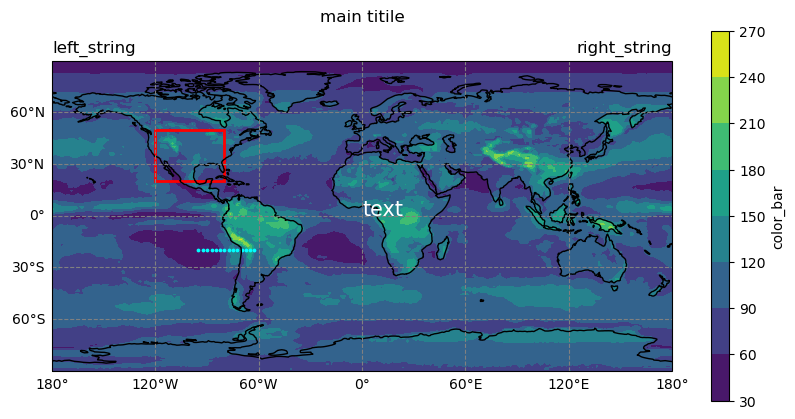

In [4]:
#--- determine map projection
#.     list of map projections: https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
map_projection = ccrs.PlateCarree(central_longitude=0)
#map_projection = ccrs.PlateCarree()

#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
data, lon_cyclic = cutil.add_cyclic_point(da_rsut.rsut.mean("time"), coord=da_rsut.lon)  

#--- plot using contourf
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut = ax.contourf(lon_cyclic, da_rsut.lat, data, transform=map_projection) 

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='vertical', shrink=0.8, label = "color_bar")
#cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='horizontal', shrink=0.8, label = "color_bar")

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
ax.set_global()

#--- add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines

# turn off labels on the top and right sides
gl.top_labels = False
gl.right_labels = False

#<--- explicitly set the grid lines and tick labels
#  explicit grid lines
#gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 30))
#gl.ylocator = plt.FixedLocator(np.arange(-90, 90, 15))

# explicitly tick labels
#ax.set_xticks(np.arange(-180, 181, 30))
#ax.set_yticks(np.arange(-90, 91, 30))
#lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
#lat_formatter = cticker.LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)
#---> explicitly set the grid lines and tick labels

#--- add texts
ax.set_title("main titile", y=1.1)
ax.set_title("left_string", loc='left')
ax.set_title("right_string", loc='right')

#--- plot a box
lon1, lon2 = -120, -80
lat1, lat2 = 20, 50
rect = mpatches.Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, facecolor='none', edgecolor='red', linewidth=2, transform=map_projection)
ax.add_patch(rect)

#--- add a text on the plot
ax.text(0, 0, 'text', fontsize = 15, color = "white")

#--- add dots
lat = -20
lon = 360 - np.array([62.5, 65., 67.25, 70, 72.5, 75., 77.25, 80,  82.5, 85, 87.25, 90., 92.5, 95.])

for lon1 in lon:
    ax.scatter(lon1, lat, s=3, c='cyan', transform=map_projection)


## Plot - a region

### select a region

In [78]:
#--- get lat/lon of the region
lowerlat = 0.  
upperlat = 60.  
lowerlon = 0.  
upperlon = 60.  

lon_slice = slice(lowerlon, upperlon)
lat_slice = slice(lowerlat, upperlat)

#--- get regional-average of the var
var_region = da_rsut.rsut.sel(lat=lat_slice, lon=lon_slice).mean("time")

#--- set U & V data
U_region = xr.zeros_like(var_region)
V_region = xr.zeros_like(var_region)

U_region[:,:]=2.
V_region[:,:]=1.

### plot - cn_map_region + wind vectors

Text(0.5, 1.1, 'cn_map_region + wind')

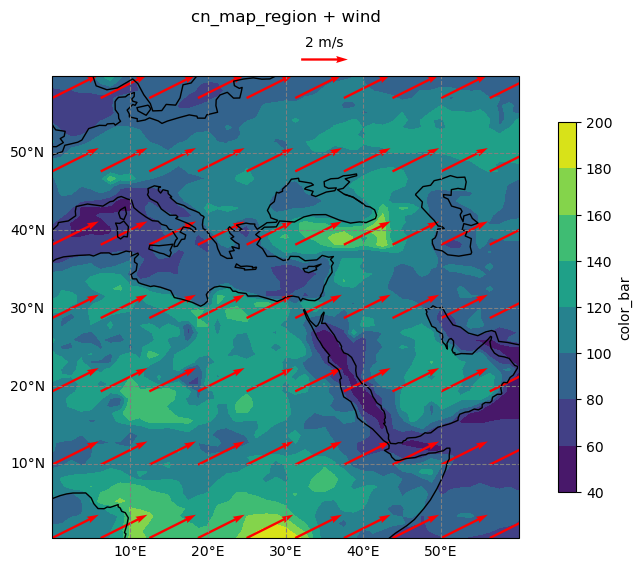

In [81]:
map_projection = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_projection})

#-------------
# plot cn_map
#-------------
cn_map_region = ax.contourf(var_region.lon, var_region.lat, var_region, transform=map_projection) 

ax.add_feature(cfeature.COASTLINE)

#--- add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines

# turn off labels on the top and right sides
gl.top_labels = False
gl.right_labels = False

#--- colorbar
cbar = plt.colorbar(cn_map_region, ax=ax, orientation='vertical', shrink=0.8, label = "color_bar")

#-------------
# plot vc_map
#-------------
lon_stride = 5
lat_stride = 10
#quiver = ax.quiver(var_region.lon, var_region.lat, U_region, V_region, scale_units='width', scale=200, color='red', width=0.005)

#--- vc_map
vc_color = 'red'
quiver = ax.quiver(var_region.lon[::lon_stride], var_region.lat[::lat_stride], U_region[::lat_stride, ::lon_stride], V_region[::lat_stride, ::lon_stride], scale_units='width', scale=20, color=vc_color, width=0.005)

#--- vc ref
key_lon = 35
key_lat = 62
key_length = 2
key_title = f"{key_length} m/s"
plot_vc_ref = ax.quiverkey(quiver, key_lon, key_lat, key_length, key_title, coordinates='data', color=vc_color)

#-----------
# set fig
#------------
title = "cn_map_region + wind"
ax.set_title(title, y=1.1)


### plot - cn_map_region

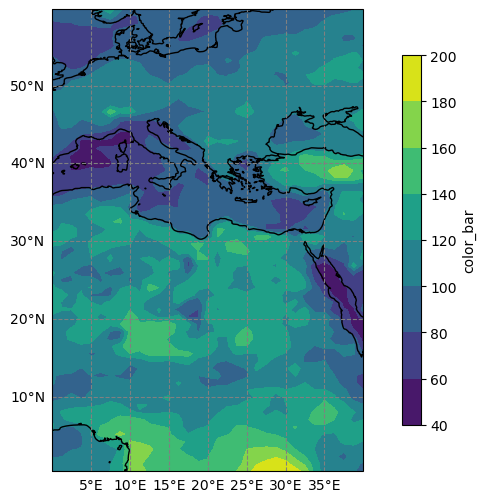

In [37]:
map_projection = ccrs.PlateCarree(central_longitude=0)

#--- plot using contourf
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut_region = ax.contourf(var_region.lon, var_region.lat, var_region, transform=map_projection) 

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut_region, ax=ax, orientation='vertical', shrink=0.8, label = "color_bar")
#cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='horizontal', shrink=0.8, label = "color_bar")

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
#ax.set_global()   ### turn it off when you want to see it on a global map

#--- add grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines

# turn off labels on the top and right sides
gl.top_labels = False
gl.right_labels = False

#--- plot wind vector
#plot_vc(ax, U_region, V_region, short_note="notes")

## CERES data

Text(0.5, 1.0, 'CERES')

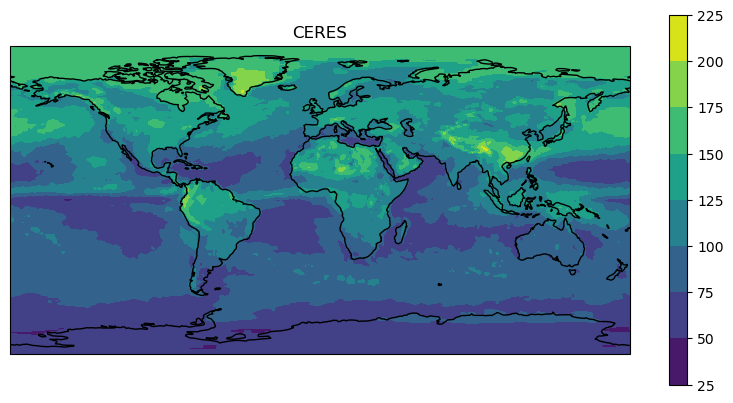

In [7]:
#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
data, lon_cyclic = cutil.add_cyclic_point(da_ceres.toa_sw_all_mon.mean("time"), coord=da_ceres.lon)  

#--- plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut = ax.contourf(lon_cyclic, da_ceres.lat, data, transform=map_projection)

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
#ax.set_global()

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='vertical', shrink=0.8)

ax.set_title("CERES")

## Interpolate CERES data on TaiESM grid, and then plot

### interpolation 
- using xarray, interp_like
- https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp_like.html
- the source_data and target_data better are (lat, lon), no time dimension


In [8]:
var_interp = da_ceres.toa_sw_all_mon.mean("time").interp_like(da_rsut.rsut.mean("time"), kwargs={"fill_value": "extrapolate"})

### plot regridded CERES data

Text(0.5, 1.0, 'CERES, regridded')

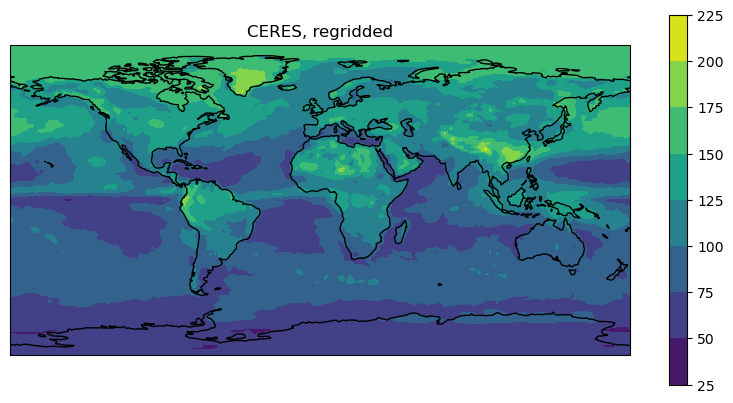

In [9]:
#--- add a cyclic point in lon, otherwise, there will be a white line at the edge
var_interp1, lon_cyclic = cutil.add_cyclic_point(var_interp, coord=var_interp.lon)  

#--- plot
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=map_projection)

cn_map_rsut = ax.contourf(lon_cyclic, var_interp.lat, var_interp1, transform=map_projection)

#--- add coast lines
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS)
#ax.set_global()

#--- plot a colorbar
cbar = plt.colorbar(cn_map_rsut, ax=ax, orientation='vertical', shrink=0.8)

ax.set_title("CERES, regridded")

### Example of xarray interp_like

In [10]:
data = np.arange(24).reshape(2,4, 3)
da1 = xr.DataArray(
    data=data,
    dims=["time","lat", "lon"],
    coords={"lat": [-60, -30, 15., 25], "lon": [0, 90, 180]},
)

da1
#print(da1[1,0])

<xarray.DataArray (time: 2, lat: 4, lon: 3)>
array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20],
        [21, 22, 23]]])
Coordinates:
  * lat      (lat) float64 -60.0 -30.0 15.0 25.0
  * lon      (lon) int64 0 90 180
Dimensions without coordinates: time

In [11]:
data2 = np.arange(12).reshape(3,2,2)
da2 = xr.DataArray(
    data=data2,
    dims=["time","lat", "lon"],
    coords={"lat": [0, 20], "lon": [60, 120]},
)
da2

<xarray.DataArray (time: 3, lat: 2, lon: 2)>
array([[[ 0,  1],
        [ 2,  3]],

       [[ 4,  5],
        [ 6,  7]],

       [[ 8,  9],
        [10, 11]]])
Coordinates:
  * lat      (lat) int64 0 20
  * lon      (lon) int64 60 120
Dimensions without coordinates: time

In [12]:
da2.interp_like(da1, kwargs={"fill_value": "extrapolate"})

<xarray.DataArray (time: 3, lat: 4, lon: 3)>
array([[[-7. , -5.5, -4. ],
        [-4. , -2.5, -1. ],
        [ 0.5,  2. ,  3.5],
        [ 1.5,  3. ,  4.5]],

       [[-3. , -1.5,  0. ],
        [ 0. ,  1.5,  3. ],
        [ 4.5,  6. ,  7.5],
        [ 5.5,  7. ,  8.5]],

       [[ 1. ,  2.5,  4. ],
        [ 4. ,  5.5,  7. ],
        [ 8.5, 10. , 11.5],
        [ 9.5, 11. , 12.5]]])
Coordinates:
  * lat      (lat) float64 -60.0 -30.0 15.0 25.0
  * lon      (lon) int64 0 90 180
Dimensions without coordinates: time

## Examples

### from ChatGPT

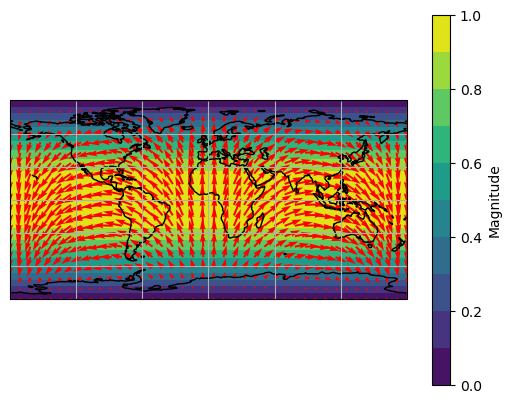

In [74]:
# Example data for illustration purposes
lon = np.linspace(-180, 180, 40)
lat = np.linspace(-90, 90, 20)
lon, lat = np.meshgrid(lon, lat)
u = np.cos(np.radians(lat)) * np.sin(np.radians(lon))
v = np.cos(np.radians(lat)) * np.cos(np.radians(lon))
magnitude = np.sqrt(u**2 + v**2)

# Create a contour plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lon, lat, magnitude, cmap='viridis', levels=10)

# Plot vectors using quiver
quiver = ax.quiver(lon, lat, u, v, scale=20, color='red', width=0.005)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
cbar.set_label('Magnitude')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Show the plot
plt.show()